In [ ]:
# https://www.sc-best-practices.org/conditions/gsea_pathway.html#id380
# Kang HM, Subramaniam M, Targ S, et al. Multiplexed droplet single-cell RNA-sequencing using natural genetic variation
#   Nat Biotechnol. 2020 Nov;38(11):1356]. Nat Biotechnol. 2018;36(1):89-94. doi:10.1038/nbt.4042

In [1]:
import numpy as np

In [2]:
from isrobust_TFM.bio import get_reactome_adj

2024-11-18 15:59:19.766647: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model_kind = "ivae_reactome"
debug = 1
frac = 0.5
seed=42

In [4]:
model_kind = str(model_kind)
debug = bool(int(debug))
frac = float(frac)

In [5]:
# TODO: read from dotenv
N_ITERS = 100

In [6]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import tensorflow as tf
from isrobust_TFM.datasets import load_kang
from isrobust_TFM.utils import set_all_seeds
from isrobust_TFM.bio import (
    get_adj_matrices,
    sync_gexp_adj,
    get_random_adj,
    build_hipathia_renamers,
    get_reactome_adj,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import dotenv
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import weightedtau


project_path = Path(dotenv.find_dotenv()).parent
results_path = project_path.joinpath("results")
results_path.mkdir(exist_ok=True, parents=True)
data_path = project_path.joinpath("data")
data_path.mkdir(exist_ok=True, parents=True)
figs_path = results_path.joinpath("figs")
figs_path.mkdir(exist_ok=True, parents=True)
tables_path = results_path.joinpath("tables")
tables_path.mkdir(exist_ok=True, parents=True)

set_all_seeds(seed=42)

tf.config.experimental.enable_op_determinism()

sc.set_figure_params(dpi=300, color_map="inferno")
sc.settings.verbosity = 1
sc.logging.print_header()

/home/alberto/amedina/TFM/robustness_informed_TFM/.pixi/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.10.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.10.8 pynndescent==0.5.13


In [7]:
results_path

PosixPath('/home/alberto/amedina/TFM/robustness_informed_TFM/results')

In [8]:
results_path =project_path.joinpath('/home/alberto/amedina/TFM/robustness_informed_TFM/notebooks/results/robustness_informed')

In [9]:
if debug:
    N_EPOCHS = 2
else:
    N_EPOCHS = 300

if model_kind == "ivae_kegg":
    n_encoding_layers = 3
elif model_kind == "ivae_reactome":
    n_encoding_layers = 2
elif "ivae_random" in model_kind:
    n_encoding_layers = 2
else:
    raise NotImplementedError(f"{model_kind} not implemented yet.")

print(f"{debug=} {model_kind=}")

debug=True model_kind='ivae_reactome'


In [10]:
if "ivae_random" in model_kind:
    n_genes = 3000
else:
    n_genes = None
adata = load_kang(data_folder=data_path, normalize=True, n_genes=n_genes)

/home/alberto/amedina/TFM/robustness_informed_TFM/.pixi/envs/default/lib/python3.11/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/alberto/amedina/TFM/robustness_informed_TFM/isrobust_TFM/datasets.py:18: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["label"] = adata.obs["label"].replace(


In [11]:
x_trans = adata.to_df()

In [12]:
circuit_adj, circuit_to_pathway_adj = get_adj_matrices(
    gene_list=x_trans.columns.to_list()
)

circuit_renamer, pathway_renamer, circuit_to_effector = build_hipathia_renamers()

kegg_circuit_names = circuit_adj.rename(columns=circuit_renamer).columns

kegg_pathway_names = circuit_to_pathway_adj.rename(columns=pathway_renamer).columns

circuit_adj.head()

circuit,P-hsa03320-62,P-hsa03320-45,P-hsa03320-43,P-hsa03320-23,P-hsa03320-32,P-hsa03320-8,P-hsa03320-7,P-hsa03320-9,P-hsa03320-39,P-hsa03320-38,...,P-hsa05164-41.42,P-hsa05164-47,P-hsa05164-53,P-hsa05164-65.66,P-hsa05164-68,P-hsa05164-70,P-hsa05164-77,P-hsa05164-78,P-hsa05164-90,P-hsa05164-99
symbol,,,,,,,,,,,,,,,,,,,,,
AKT3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TANK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BCL2L11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SH2B3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FRAT1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
reactome = get_reactome_adj()
reactome_pathway_names = reactome.columns

In [14]:
if model_kind == "ivae_kegg":
    x_trans, circuit_adj = sync_gexp_adj(gexp=x_trans, adj=circuit_adj)
elif model_kind == "ivae_reactome":
    x_trans, reactome = sync_gexp_adj(x_trans, reactome)

In [15]:
state = np.random.get_state()

# we ensure to presever the same sparsity structure for a given frac across all seeds
random_layer, random_layer_names = get_random_adj(
    frac, shape=reactome.shape, size=reactome.size, index=reactome.index, seed=0
)

np.random.set_state(state)

In [16]:
if model_kind == "ivae_kegg":
    x_trans, circuit_adj = sync_gexp_adj(gexp=x_trans, adj=circuit_adj)
elif model_kind == "ivae_reactome":
    x_trans, reactome = sync_gexp_adj(x_trans, reactome)
elif "ivae_random" in model_kind:
    x_trans, random_layer = sync_gexp_adj(x_trans, random_layer)

In [17]:
def get_importances(data, abs=False):
    if abs:
        return np.abs(data).mean(axis=0)
    else:
        return data.mean(axis=0)


def get_activations(act_model, layer_id, data):
    data_encoded = act_model.predict(data)[layer_id]
    return data_encoded

In [18]:
def train_val_test_split(features, val_size, test_size, stratify, seed):
    train_size = 1 - (val_size + test_size)

    x_train, x_test, y_train, y_test = train_test_split(
        features,
        stratify,
        train_size=train_size,
        stratify=stratify,
        random_state=seed,
    )

    x_val, x_test = train_test_split(
        x_test,
        test_size=test_size / (test_size + val_size),
        stratify=y_test,
        random_state=seed,
    )

    x_train = x_train.astype("float32")
    x_val = x_val.astype("float32")
    x_test = x_test.astype("float32")

    return x_train, x_val, x_test

In [19]:
results_path_model = results_path.joinpath(model_kind)
obs = adata.obs.copy()
results_path_model.mkdir(exist_ok=True, parents=True)

In [20]:
if model_kind == "ivae_kegg":
    # vae, encoder, decoder = build_kegg_vae(
    #     circuits=circuit_adj, pathways=circuit_to_pathway_adj, seed=42
    # )
    layer_ids = [1, 2, 5]
elif model_kind == "ivae_reactome":
    # vae, encoder, decoder = build_reactome_vae(reactome, seed=42)
    layer_ids = [1, 4]
elif "ivae_random" in model_kind:
    # vae, encoder, decoder = build_reactome_vae(random_layer, seed=42)
    layer_ids = [1, 4]
else:
    raise NotImplementedError("Model not yet implemented.")

In [21]:
non_layer_names = ["split", "layer", "seed", "cell_type", "condition", "model"]

In [23]:
f"metrics-seed-{seed:02d}.pkl"

'metrics-seed-42.pkl'

In [24]:
scores_metrics

NameError: name 'scores_metrics' is not defined

In [25]:
scores_metrics = [
    pd.read_pickle(results_path_model.joinpath(f"metrics-seed-{seed:02d}.pkl"))
#     for seed in range(N_ITERS)
]
scores_metrics = pd.concat(scores_metrics, axis=0, ignore_index=True)
scores_metrics.to_pickle(results_path_model.joinpath("scores_metrics.pkl"))

scores_metrics.head()

,seed,metric,split,score,model
0,42,loss,train,14.565618,ivae_reactome
1,42,mse,train,0.008969,ivae_reactome
2,42,loss,val,14.534306,ivae_reactome
3,42,mse,val,0.008989,ivae_reactome
4,42,loss,test,14.558331,ivae_reactome


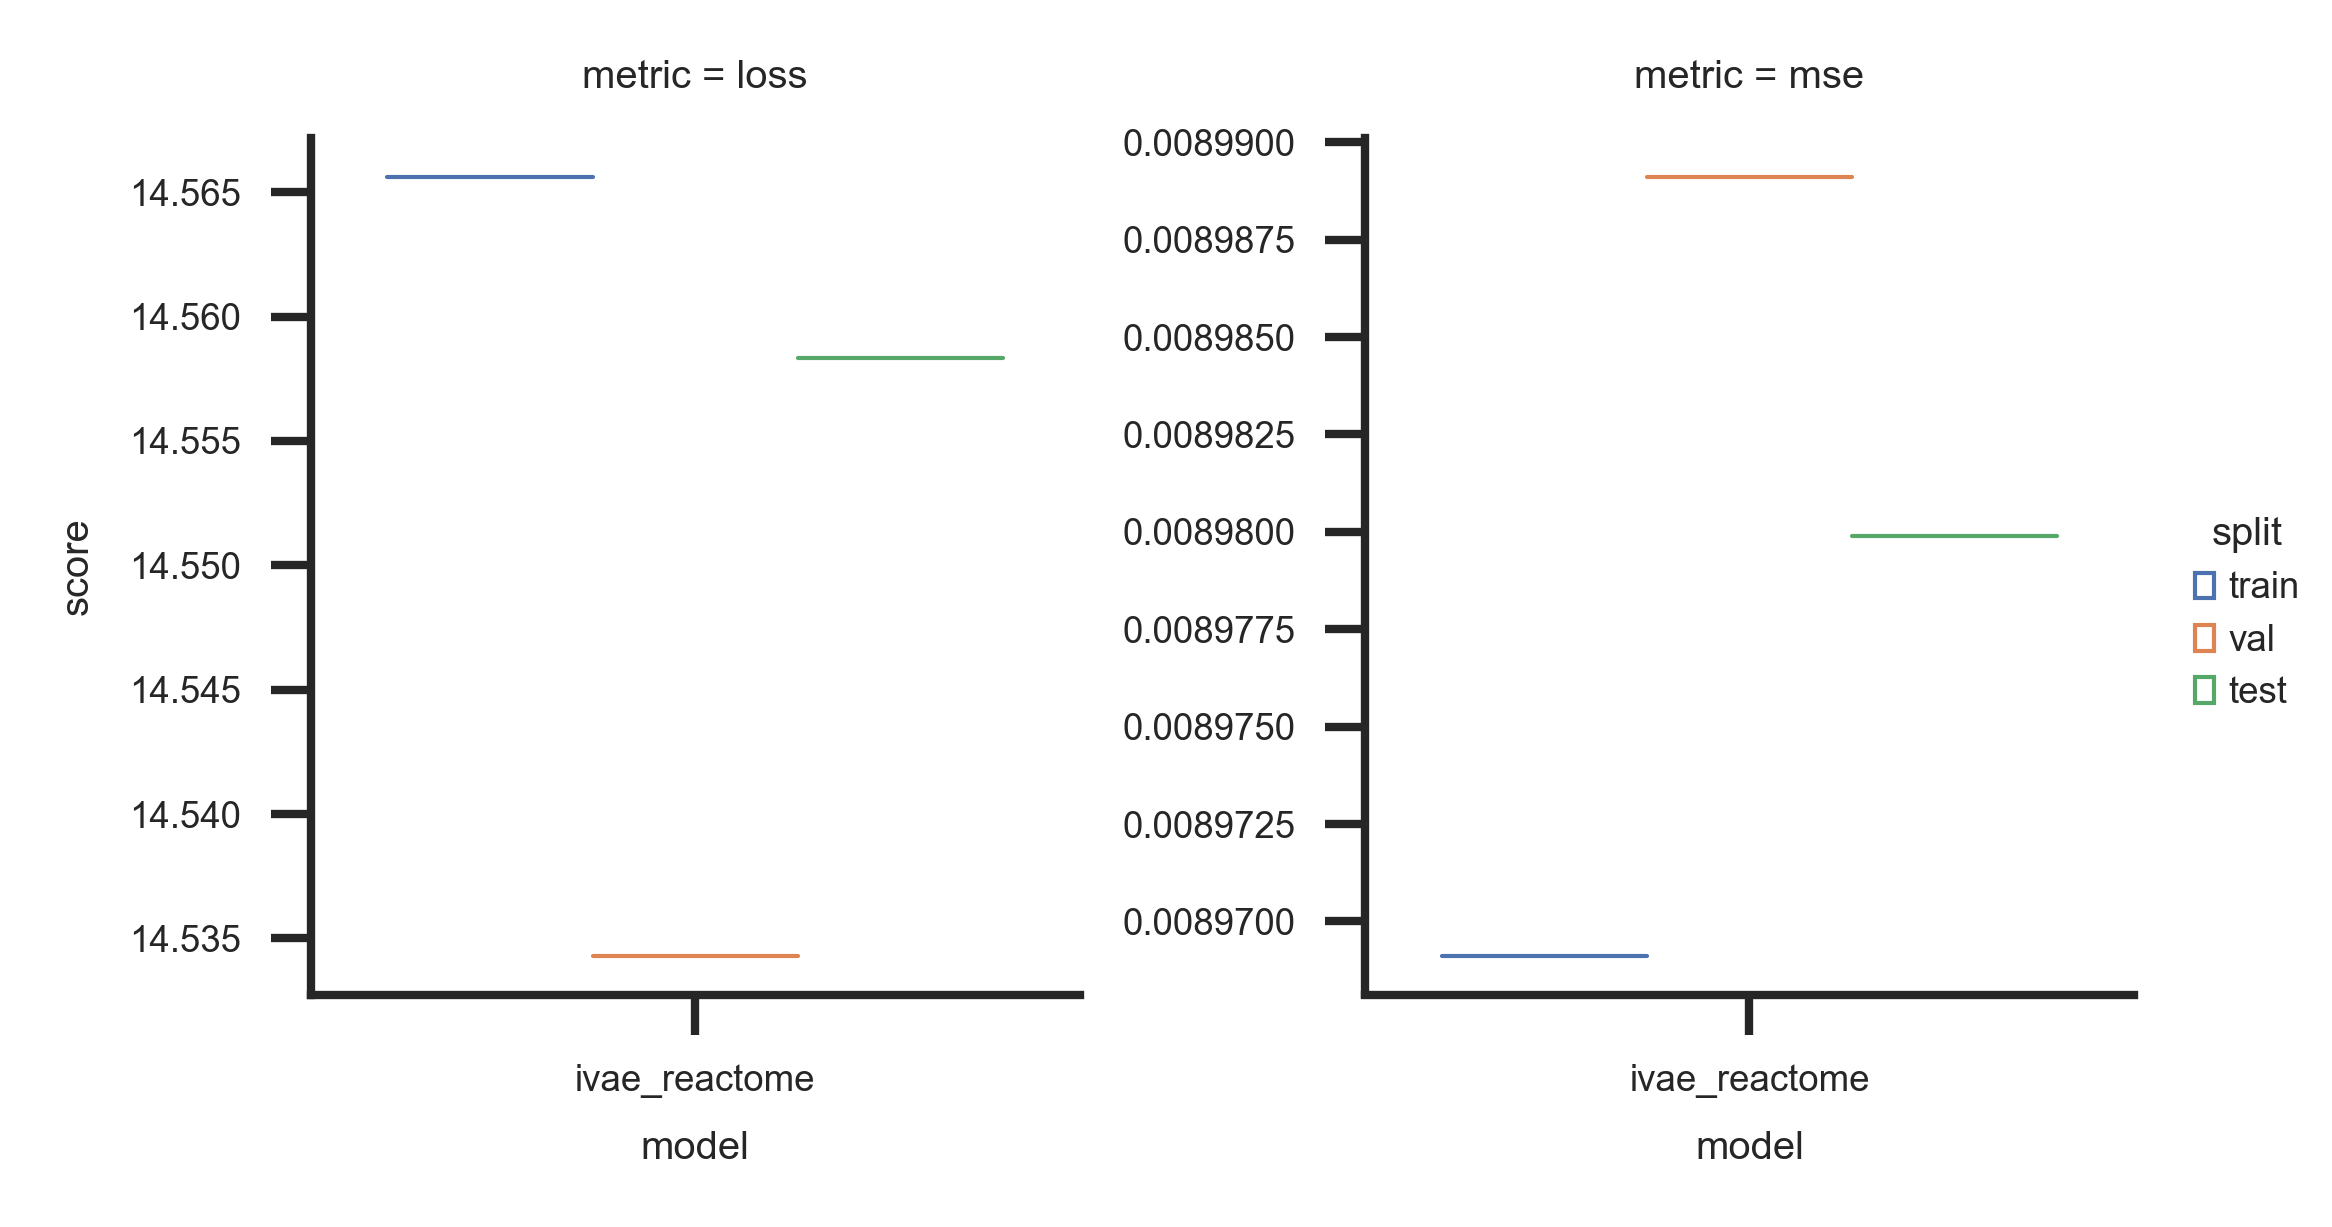

In [26]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=0.5, style="ticks", rc=custom_params)

g = sns.catplot(
    data=scores_metrics,
    kind="violin",
    col="metric",
    height=2,
    aspect=0.9,
    sharey=False,
    x="model",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=0.5,
)

In [27]:
scores_informed = {}

for layer_id in layer_ids:
    if results_path_model.joinpath(
        f"encodings_layer-{layer_id:02d}_seed-00.pkl"
    ).exists():
        results_layer = [
            pd.read_pickle(
                results_path_model.joinpath(
                    f"encodings_layer-{layer_id:02d}_seed-{seed:02d}.pkl"
                )
            )
            for seed in range(N_ITERS)
        ]
    else:
        continue

    scores_informed[layer_id] = {}
    for split in ["train", "test", "val"]:
        results = [
            x.loc[x["split"] == split].drop(non_layer_names, axis=1)
            for x in results_layer
        ]
        scores_informed[layer_id][split] = []
        for seed_i in range(N_ITERS):
            for seed_j in range(seed_i + 1, N_ITERS):
                scores_informed[layer_id][split].append(
                    weightedtau(
                        get_importances(data=results[seed_i], abs=True),
                        get_importances(data=results[seed_j], abs=True),
                    )[0]
                )

In [28]:
scores_informed = (
    pd.DataFrame.from_dict(scores_informed)
    .melt(var_name="layer", value_name="score", ignore_index=False)
    .reset_index(names=["split"])
    .explode("score")
)
scores_informed["score"] = scores_informed["score"].astype("float")
scores_informed["model"] = model_kind
scores_informed.to_pickle(results_path_model.joinpath("scores_informed.pkl"))

In [29]:
scores_informed.head()

,split,layer,score,model


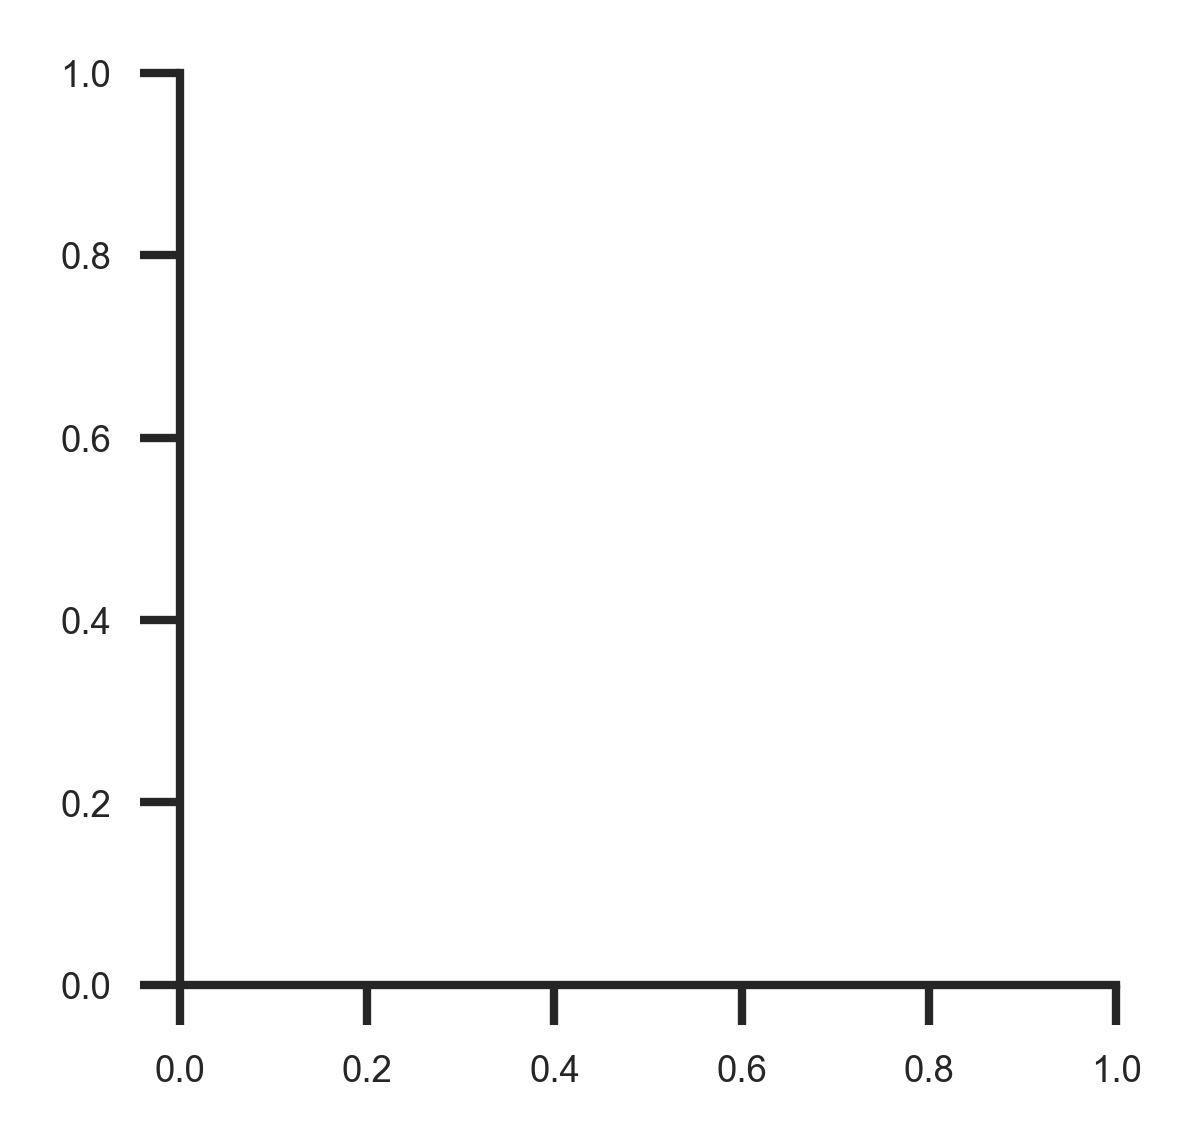

In [30]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=0.5, style="ticks", rc=custom_params)
plt.figure(figsize=(2, 2))
sns.violinplot(
    data=scores_informed,
    x="layer",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=0.5,
)
sns.despine()

In [31]:
from sklearn.cluster import MiniBatchKMeans
from multiprocessing import cpu_count
from sklearn.metrics.cluster import adjusted_mutual_info_score

batch_size = 256 * cpu_count() + 1

In [32]:
clust_scores = {}

for layer_id in layer_ids:
    if results_path_model.joinpath(
        f"encodings_layer-{layer_id:02d}_seed-00.pkl"
    ).exists():
        results_layer = [
            pd.read_pickle(
                results_path_model.joinpath(
                    f"encodings_layer-{layer_id:02d}_seed-{seed:02d}.pkl"
                )
            )
            for seed in range(N_ITERS)
        ]
    else:
        continue

    train_embeddings_lst = [
        x.loc[(x["split"] == "train") & (x["condition"] == "control")]
        for x in results_layer
    ]
    val_embeddings_lst = [
        x.loc[(x["split"] == "val") & (x["condition"] == "control")]
        for x in results_layer
    ]
    test_embeddings_lst = [
        x.loc[(x["split"] == "test") & (x["condition"] == "control")]
        for x in results_layer
    ]

    clust_scores[layer_id] = {}
    clust_scores[layer_id]["train"] = []
    clust_scores[layer_id]["val"] = []
    clust_scores[layer_id]["test"] = []

    for seed in range(N_ITERS):
        y_train = train_embeddings_lst[seed]["cell_type"]
        y_val = val_embeddings_lst[seed]["cell_type"]
        y_test = test_embeddings_lst[seed]["cell_type"]

        train_embeddings = train_embeddings_lst[seed].drop(non_layer_names, axis=1)
        val_embeddings = val_embeddings_lst[seed].drop(non_layer_names, axis=1)
        test_embeddings = test_embeddings_lst[seed].drop(non_layer_names, axis=1)

        model = MiniBatchKMeans(n_clusters=y_train.nunique(), batch_size=batch_size)
        model.fit(train_embeddings)
        clust_scores[layer_id]["train"].append(
            adjusted_mutual_info_score(y_train, model.labels_)
        )
        clust_scores[layer_id]["val"].append(
            adjusted_mutual_info_score(y_val, model.predict(val_embeddings))
        )
        clust_scores[layer_id]["test"].append(
            adjusted_mutual_info_score(y_test, model.predict(test_embeddings))
        )

In [33]:
clust_scores = (
    pd.DataFrame.from_dict(clust_scores)
    .melt(var_name="layer", value_name="score", ignore_index=False)
    .reset_index(names=["split"])
    .explode("score")
)
clust_scores["score"] = clust_scores["score"].astype("float")
clust_scores["model"] = model_kind
clust_scores.to_pickle(results_path_model.joinpath("scores_clustering.pkl"))

In [34]:
clust_scores.head()

,split,layer,score,model


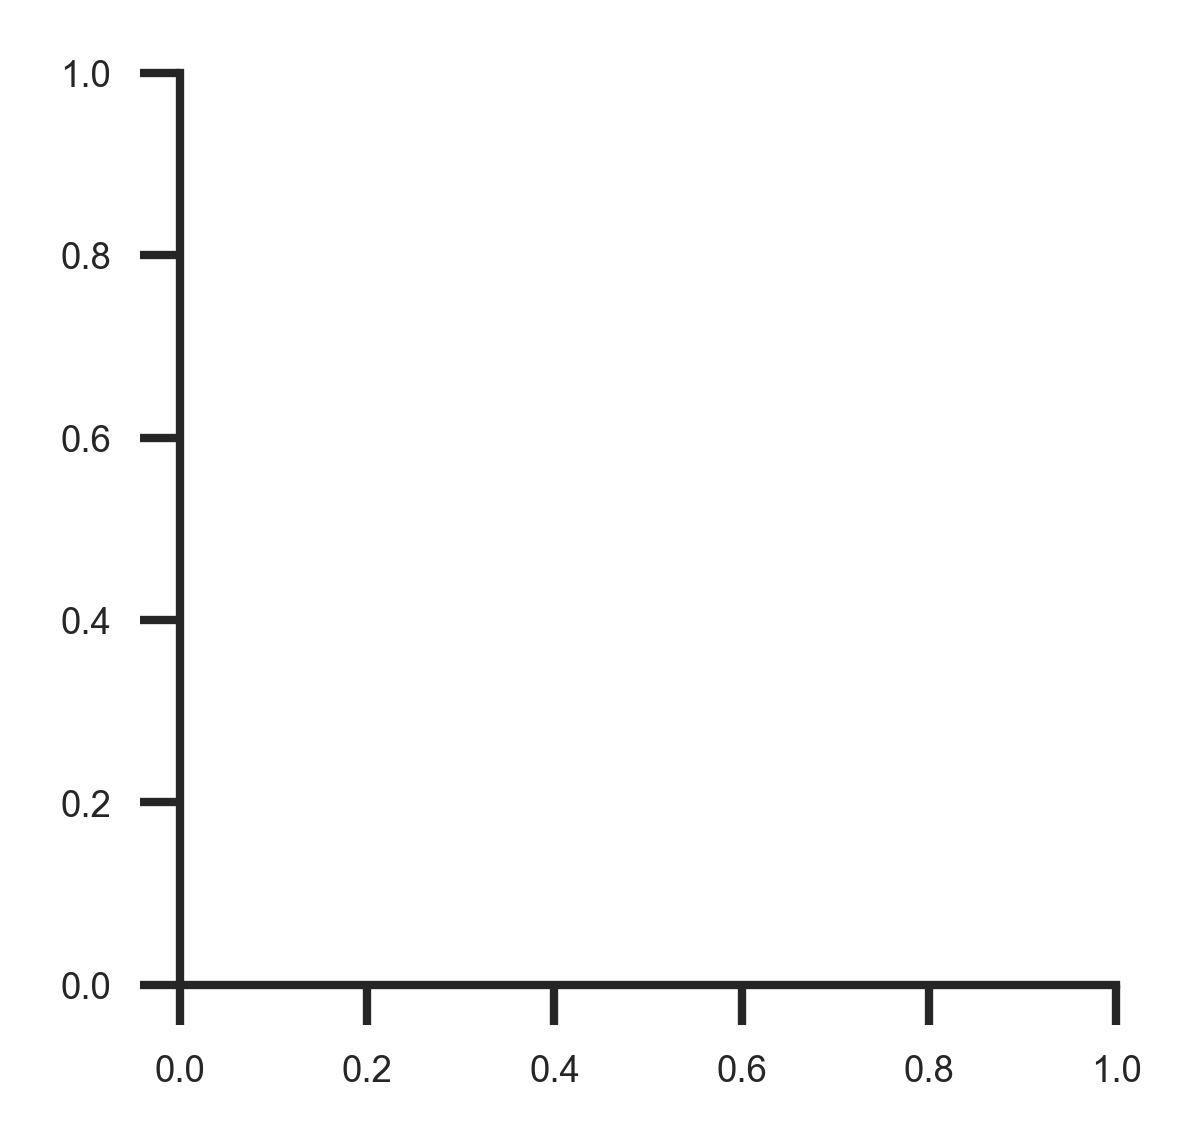

In [35]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=0.5, style="ticks", rc=custom_params)
plt.figure(figsize=(2, 2))
sns.violinplot(
    data=clust_scores,
    x="layer",
    y="score",
    hue="split",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=0.5,
)
sns.despine()